## Dataset Tools - OSM to GeoJSON + Visualizer
This notebook is used to convert OSM data to GeoJSON. Only the geometry related data along with type of the geometries is preserved.

Unnecessary/unrelated data in the OSM set is removed during conversion. The notebook also contains interactive visualization of the data.

In [1]:
#%pip install osmnx
#%pip install folium
#%pip install tqdm
#%pip install jsonlines
import jsonlines
import glob
import osmnx as ox
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
import tqdm
import shapely
import random
import os
from shapely.wkt import loads
import re
import seaborn as sns

Documentation for osmnx (used for downloading the data): https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.geometries 

OSM data model explained (nodes, ways, relations): https://labs.mapbox.com/mapping/osm-data-model/

Plotting polygons with Folium: https://geopandas.org/en/stable/gallery/polygon_plotting_with_folium.html 

List of possible tags: https://wiki.openstreetmap.org/wiki/Map_features

#### Downloads geometry data from OSM and stores in variable.
Specify a coordinate and radius, and the program will do the rest.

In [2]:
RADIUS, GEOCODE, LOCAL = 0,1,2
tags = []

TYPE = LOCAL
origin = (55.70293, 13.19914) # coordinates for origin, now Lund
dist = 2 * 10000 # distance in m (mil left part)
zoom_start = 14

if TYPE == RADIUS:
    tags = ['building', 'highway'] # Specify the types to get, see above link for possible tags
    dist = 2000
    #tags = ['boundary']
    df = ox.geometries.geometries_from_point(origin, {x: True for x in tags}, dist=dist)
    #tags = {'boundary': ['place']}
    #df = ox.geometries.geometries_from_point(origin, tags, dist=dist)

elif TYPE == GEOCODE:
    df = ox.geocode_to_gdf('USA')

elif TYPE == LOCAL:
    zoom_start = 3
    SINGLE_SHP_FILE = False
    if SINGLE_SHP_FILE:
        df = gpd.read_file('data/ne_10m_admin_1_states_provinces.shp')
        #df = gpd.read_file('data/sweden-latest-free/gis_osm_buildings_a_free_1.shp')
        #df = gpd.read_file('data/sweden-latest-free/gis_osm_roads_free_1.shp')
        #print(df)
    else:
        df = gpd.GeoDataFrame()
        shp_base_loc = 'data/sweden-latest-free'
        files = glob.glob(shp_base_loc + '/*.shp')
        for i in tqdm.tqdm(range(len(files))):
            f = files[i]
            print(i + 1, ':', f)
            to_append = gpd.read_file(f)
            print(i + 1, 'contains', len(to_append), 'geometries')
            df = gpd.pd.concat([df, to_append], copy=False)

# Filter to only keep polygons, i.e. skip ex. LineString, Point
#df = df[df.type == "Polygon"]

# Remove Points, i.e. keep only geometries
df = df[df.type != "Point"]
print("Count of entries:", len(df))

  0%|          | 0/18 [00:00<?, ?it/s]

1 : data/sweden-latest-free/gis_osm_landuse_a_free_1.shp
1 contains 1059602 geometries


  6%|▌         | 1/18 [03:23<57:32, 203.10s/it]

2 : data/sweden-latest-free/gis_osm_natural_free_1.shp
2 contains 219639 geometries


 11%|█         | 2/18 [03:46<26:02, 97.63s/it] 

3 : data/sweden-latest-free/gis_osm_buildings_a_free_1.shp
3 contains 2827275 geometries


 17%|█▋        | 3/18 [11:28<1:05:54, 263.62s/it]

4 : data/sweden-latest-free/gis_osm_waterways_free_1.shp
4 contains 103816 geometries


 22%|██▏       | 4/18 [11:43<38:39, 165.71s/it]  

5 : data/sweden-latest-free/gis_osm_pofw_free_1.shp
5 contains 772 geometries


 28%|██▊       | 5/18 [11:45<23:05, 106.60s/it]

6 : data/sweden-latest-free/gis_osm_water_a_free_1.shp
6 contains 295715 geometries


 33%|███▎      | 6/18 [12:45<18:07, 90.63s/it] 

7 : data/sweden-latest-free/gis_osm_transport_free_1.shp
7 contains 52077 geometries


 39%|███▉      | 7/18 [12:53<11:41, 63.77s/it]

8 : data/sweden-latest-free/gis_osm_places_a_free_1.shp
8 contains 1587 geometries


 44%|████▍     | 8/18 [12:56<07:24, 44.46s/it]

9 : data/sweden-latest-free/gis_osm_natural_a_free_1.shp
9 contains 3465 geometries


 50%|█████     | 9/18 [12:59<04:42, 31.37s/it]

10 : data/sweden-latest-free/gis_osm_places_free_1.shp
10 contains 66431 geometries


 56%|█████▌    | 10/18 [13:09<03:19, 24.90s/it]

11 : data/sweden-latest-free/gis_osm_pofw_a_free_1.shp
11 contains 3753 geometries


 61%|██████    | 11/18 [13:12<02:06, 18.08s/it]

12 : data/sweden-latest-free/gis_osm_pois_free_1.shp
12 contains 125170 geometries


 67%|██████▋   | 12/18 [13:29<01:46, 17.81s/it]

13 : data/sweden-latest-free/gis_osm_traffic_a_free_1.shp
13 contains 78754 geometries


 72%|███████▏  | 13/18 [13:43<01:23, 16.64s/it]

14 : data/sweden-latest-free/gis_osm_traffic_free_1.shp
14 contains 317307 geometries


 78%|███████▊  | 14/18 [14:25<01:37, 24.29s/it]

15 : data/sweden-latest-free/gis_osm_railways_free_1.shp
15 contains 25885 geometries


 83%|████████▎ | 15/18 [14:31<00:56, 18.83s/it]

16 : data/sweden-latest-free/gis_osm_transport_a_free_1.shp
16 contains 852 geometries


 89%|████████▉ | 16/18 [14:34<00:28, 14.04s/it]

17 : data/sweden-latest-free/gis_osm_pois_a_free_1.shp
17 contains 76334 geometries


 94%|█████████▍| 17/18 [14:49<00:14, 14.47s/it]

18 : data/sweden-latest-free/gis_osm_roads_free_1.shp
18 contains 1904260 geometries


100%|██████████| 18/18 [20:14<00:00, 67.46s/it] 


Count of entries: 6381298


In [3]:
# Preview filtered data
# df.geometry.plot(figsize=(6, 6))
# plt.axis('off')
# plt.show()

In [4]:
# Folium wants coordinate system: EPSG:4326. OK!
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### Export to GeoJSON
Below, the tag (type) of each polygon is found, irrelevant data is removed, and the final data-frame is serialized and saved as GeoJSON.

The export location is "data/latest_export.json".

In [16]:
# Construct type column
df_stripped = []
for i in tqdm.tqdm(range(len(df))):
    r = df.iloc[i]
    found_tag = None
    for tag in tags:
        if str(r[tag]) != 'nan':
            #if found_tag != None: raise Exception("Ambiguity found!")
            found_tag = tag
    df_stripped.append({'type': found_tag, 'geometry': r.geometry})

df_stripped = gpd.GeoDataFrame(df_stripped)

ONE_FILE = True
SAVE = False
MAX_ENTRIES_FILE = 100000
NUM_DECIMALS = -1 # -1 for no change

if NUM_DECIMALS != -1:
    simple_dec = re.compile(r"\d*\.\d+")
    def m_round(match):
        return ("{:." + str(NUM_DECIMALS) + "f}").format(float(match.group()))
    df_stripped.geometry = df_stripped.geometry.apply(lambda x: loads(re.sub(simple_dec, m_round, x.wkt)))

if SAVE:
    if ONE_FILE:
        # Avoid to large files -> sample data
        if len(df_stripped) > MAX_ENTRIES_FILE:
            keep_idxs = [random.randint(0, len(df_stripped) - 1) for i in range(MAX_ENTRIES_FILE)]
            df_stripped = df_stripped.loc[keep_idxs]
        df_stripped.to_file(filename='data/latest_export.json', driver='GeoJSON')
    else:
        OUT_FOLDER = 'data/latest_export'
        if not os.path.exists(OUT_FOLDER):
            os.makedirs(OUT_FOLDER)
        for f in glob.glob(OUT_FOLDER + '/*'):
            os.remove(f)
        for i in tqdm.tqdm(range(len(df_stripped))):
            r = df_stripped.iloc[i]
            geo = gpd.GeoSeries(r['geometry']) # Parse Geometry for row to generate JSON
            geo = gpd.GeoDataFrame({'type': r['type'], 'geometry': geo}) # Type is needed for coloring
            geo_json = geo.to_json() #[43:-2] # Remove FeatureCollection part
            # Write to disk
            f = open(f"{OUT_FOLDER}/{i}.json", "w")
            f.write(geo_json)
            f.close()

  0%|          | 1431/6381298 [00:00<14:36, 7274.75it/s]

POLYGON ((17.4992647 59.4906194, 17.4993076 59.4909331, 17.4995222 59.491029, 17.4997024 59.4909985, 17.4999685 59.4907545, 17.500226 59.4902621, 17.5004406 59.4900529, 17.5007066 59.4897217, 17.5014877 59.4890332, 17.5015049 59.4887413, 17.5013675 59.4886367, 17.5012216 59.4885234, 17.5011186 59.4883665, 17.5011014 59.4882096, 17.5009727 59.488166, 17.5007238 59.4882096, 17.500329 59.4884493, 17.4999341 59.4887674, 17.4997024 59.489103, 17.4994106 59.4898002, 17.4994277 59.490018, 17.4992647 59.4906194))
POLYGON ((17.5764591 59.4845262, 17.5766479 59.4847092, 17.5769741 59.4847964, 17.5774032 59.4847005, 17.5774891 59.4845349, 17.57737 59.48442, 17.5772058 59.484195, 17.5770342 59.4840468, 17.5768368 59.4841078, 17.5767338 59.4842385, 17.5764591 59.4845262))
POLYGON ((17.4899916 59.4839169, 17.4900431 59.4841174, 17.4902147 59.4842176, 17.4905323 59.4841697, 17.4909014 59.4839997, 17.491176 59.4839692, 17.4913734 59.483991, 17.4916653 59.4839605, 17.4918627 59.4838254, 17.4923004 59.4

  0%|          | 2884/6381298 [00:00<18:57, 5606.36it/s]

POLYGON ((16.0369041 56.9875985, 16.0371652 56.9877108, 16.0373869 56.9876221, 16.0376337 56.987768, 16.0379126 56.9877852, 16.0375371 56.9880482, 16.0378922 56.9882584, 16.0383632 56.9882064, 16.0382148 56.9885559, 16.0385885 56.9887026, 16.0388846 56.988733, 16.0399725 56.9885626, 16.040112 56.9887844, 16.0379877 56.9892231, 16.037816 56.9893456, 16.0388997 56.9896445, 16.038728 56.9898424, 16.0384705 56.9899067, 16.0383632 56.990158, 16.0377624 56.9904389, 16.0382312 56.9910389, 16.0381701 56.9913571, 16.0385324 56.9914244, 16.0387173 56.9918302, 16.0390499 56.9917545, 16.0391208 56.9921774, 16.0395434 56.9920868, 16.0398545 56.9923504, 16.0394039 56.9926011, 16.0398545 56.992841, 16.0402086 56.993256, 16.0405803 56.9931081, 16.041 56.99275, 16.0411045 56.9923844, 16.0408416 56.9921166, 16.0411978 56.9920577, 16.0413367 56.9915717, 16.0410454 56.9913983, 16.0412643 56.9912335, 16.0411205 56.9909471, 16.0414558 56.9909295, 16.0419145 56.9907896, 16.0419359 56.9905733, 16.0422162 56.9

  0%|          | 4253/6381298 [00:00<17:03, 6231.95it/s]

POLYGON ((18.2060961 59.6736946, 18.2068686 59.6736946, 18.2072977 59.6736079, 18.2071464 59.6739634, 18.2065877 59.6740421, 18.2065416 59.6741325, 18.206654 59.674648, 18.2073836 59.674648, 18.2082558 59.6751325, 18.2094504 59.6750716, 18.2094006 59.6745397, 18.2095958 59.6743725, 18.2098463 59.6744415, 18.2102589 59.6743447, 18.2102589 59.6738896, 18.2097076 59.6739244, 18.2094979 59.6734317, 18.2089582 59.6734169, 18.2088439 59.6736171, 18.2086476 59.6735793, 18.2081013 59.6737397, 18.2080334 59.6736741, 18.2079415 59.6727195, 18.2063965 59.6727845, 18.2060961 59.6736946))
POLYGON ((18.1697039 59.6707042, 18.1697039 59.6718527, 18.1700472 59.6728712, 18.1706051 59.6729145, 18.1721071 59.6735646, 18.1724934 59.6735863, 18.172708 59.6741713, 18.17421 59.674453, 18.1746821 59.6742363, 18.174725 59.673998, 18.1754116 59.673868, 18.1763128 59.673933, 18.1769995 59.6738463, 18.1770424 59.6726328, 18.1783299 59.6705741, 18.1794457 59.6709425, 18.1800036 59.6703791, 18.1790594 59.669924, 18

  0%|          | 5643/6381298 [00:00<18:54, 5620.70it/s]

POLYGON ((13.0074963 55.4787974, 13.0076952 55.4819536, 13.0096358 55.4813496, 13.0096251 55.4788469, 13.0095756 55.4785597, 13.008734 55.4786389, 13.0074963 55.4787974))
POLYGON ((13.0086845 55.4774211, 13.008734 55.4786389, 13.0095756 55.4785597, 13.0095261 55.4773814, 13.0092885 55.4773715, 13.0086845 55.4774211))
POLYGON ((13.0096251 55.4788469, 13.0096358 55.4813496, 13.0108339 55.4809512, 13.0106945 55.4787577, 13.0096251 55.4788469))
POLYGON ((13.0106945 55.4787577, 13.0108339 55.4809512, 13.0117172 55.480676, 13.0122238 55.4805931, 13.0123111 55.4803933, 13.0124628 55.4802573, 13.012627 55.4800504, 13.0127559 55.4796317, 13.0128384 55.4792434, 13.0128384 55.4788662, 13.0127368 55.4786096, 13.0125659 55.4784473, 13.0120908 55.4784544, 13.0114263 55.4784665, 13.0113355 55.4786503, 13.0106945 55.4787577))
POLYGON ((12.2688299 57.8465629, 12.2694136 57.8467502, 12.2701002 57.846636, 12.2706324 57.8456265, 12.2711473 57.8456265, 12.2714869 57.8451367, 12.2707783 57.844987, 12.269885

  0%|          | 6881/6381298 [00:01<18:06, 5869.62it/s]

POLYGON ((17.5931033 59.8414225, 17.5933007 59.8415754, 17.5935393 59.8417386, 17.5937586 59.8416655, 17.5939989 59.8416137, 17.5942821 59.8417086, 17.5945396 59.8418164, 17.5946254 59.8419587, 17.594634 59.8420449, 17.5948143 59.8420622, 17.5950117 59.8421312, 17.5949773 59.8422304, 17.5947714 59.842295, 17.5945482 59.8422864, 17.59419 59.8422043, 17.5945045 59.8424324, 17.5947318 59.8424909, 17.595357 59.8426248, 17.5955926 59.8426763, 17.5958248 59.8427425, 17.5960507 59.842826, 17.5961509 59.8426197, 17.596156 59.8425778, 17.5960444 59.8424442, 17.5959146 59.8423804, 17.5955466 59.8419698, 17.5955623 59.8418639, 17.5957187 59.8418275, 17.5958836 59.8418402, 17.5960297 59.8418533, 17.5963526 59.8418965, 17.5966349 59.8419666, 17.5968426 59.8420733, 17.5969539 59.842263, 17.5968475 59.8423277, 17.5968595 59.8424657, 17.5969792 59.8425743, 17.5969806 59.8426522, 17.5969427 59.8427277, 17.5971065 59.8426423, 17.5972532 59.8425666, 17.5971477 59.8424076, 17.5971561 59.8421735, 17.597130

  0%|          | 8062/6381298 [00:01<20:43, 5126.61it/s]

POLYGON ((18.0075034 59.2499791, 18.0077587 59.2501359, 18.0078234 59.2504346, 18.0085197 59.2504194, 18.0085335 59.2503555, 18.0081116 59.2499617, 18.0078222 59.2498159, 18.0075034 59.2499791))
POLYGON ((13.8093371 55.4281561, 13.8108906 55.4290084, 13.8121889 55.4295614, 13.8130027 55.4289567, 13.8117091 55.4283044, 13.810614 55.4276705, 13.8093371 55.4281561))
POLYGON ((13.7908506 55.4249742, 13.7910569 55.4263019, 13.7941167 55.4261779, 13.7985638 55.426146, 13.7986501 55.4254075, 13.7964933 55.4253283, 13.7946001 55.4251609, 13.7932874 55.4249632, 13.7908506 55.4249742))
POLYGON ((13.810614 55.4276705, 13.8117091 55.4283044, 13.8130027 55.4289567, 13.8121889 55.4295614, 13.8126538 55.4298201, 13.8135005 55.4303536, 13.8138913 55.4306875, 13.8141943 55.4309205, 13.8145918 55.4311297, 13.8163133 55.4318271, 13.8163887 55.4317751, 13.8162728 55.4317327, 13.8164522 55.4315744, 13.8165968 55.4316132, 13.816625 55.431573, 13.8155028 55.4311599, 13.8149717 55.4308168, 13.8147447 55.43038

  0%|          | 8676/6381298 [00:01<18:27, 5754.37it/s]


POLYGON ((17.9494763 62.6277031, 17.9512396 62.6287623, 17.9513919 62.6287757, 17.9523517 62.6284598, 17.9505631 62.6273408, 17.9494763 62.6277031))
POLYGON ((17.9538918 62.6323206, 17.9546655 62.6327146, 17.9550783 62.6330691, 17.9555763 62.6329733, 17.954616 62.6320811, 17.9545516 62.6320706, 17.9538918 62.6323206))
POLYGON ((17.9563002 62.628913, 17.9565646 62.6291907, 17.9565966 62.6292911, 17.9580009 62.6291173, 17.9586902 62.6289989, 17.9593542 62.6288399, 17.9601672 62.628634, 17.9603354 62.6285815, 17.9601017 62.6284015, 17.9598554 62.6283592, 17.9597233 62.6283688, 17.9595823 62.6283903, 17.9591746 62.6284187, 17.9563002 62.628913))
POLYGON ((17.9620106 62.6279432, 17.9625318 62.6282509, 17.9630318 62.6281148, 17.963918 62.6278028, 17.9653923 62.6272517, 17.9648848 62.6269852, 17.9647691 62.6269923, 17.9636764 62.6274303, 17.9624453 62.6278225, 17.9620106 62.6279432))
POLYGON ((17.9649478 62.6269272, 17.9649608 62.6269725, 17.9654473 62.6272326, 17.9674404 62.6263772, 17.96745

KeyboardInterrupt: 

#### Visualizer
Below, an interactive map of the polygons is generated. The different types are represented by different fill colors.

By setting SHOW_TILES to True, the OSM is rendered in the background. Setting it to False allows for a more obvious visualization of the polygons.

In [6]:
DO_VISUALIZATION = False
SHOW_TILES = False

if DO_VISUALIZATION:
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray']
    tag_colors = {x: colors[idx % len(colors)] for idx, x in enumerate(tags)}

    map = folium.Map(location=[origin[0], origin[1]], zoom_start=zoom_start, tiles='CartoDB positron' if SHOW_TILES else None)

    for _, r in df_stripped.iterrows():
        geo = gpd.GeoSeries(r['geometry']) # Parse Geometry for row to generate JSON
        geo = gpd.GeoDataFrame({'type': r['type'], 'geometry': geo}) # Type is needed for coloring
        geo_json = geo.to_json()
        geo_json = folium.GeoJson(data=geo_json,
                            style_function=lambda x: {
                                    'weight': '1',
                                    'fillOpacity': '0.7',
                                    'fillColor': tag_colors[x['properties']['type']] if x['properties']['type'] != None else 'cyan'
                                })
        geo_json.add_to(map)
if DO_VISUALIZATION:
    display(map)

#### Statistics of dataset

In [7]:
IMPORT_INTERSECTION_DATA = False
EXPORT_INTERSECTION_DATA = False
INCL_INTERSECTION_DATA = False

op_df = df_stripped.copy()
#display(op_df)

In [8]:
def nbr_verticies(geometry):
    return  shapely.count_coordinates(geometry)

def geo_length(geometry):
    return  shapely.length(geometry)

def geo_area(geometry):
 return shapely.area(geometry)

def geo_type(geometry):
    return geometry.geom_type

def count_intersections(geometry):
    geo1_total = 0
    for geo2 in df_stripped['geometry']:
        if not shapely.equals_exact(geometry, geo2):
            if shapely.intersects(geometry, geo2):
                geo1_total += 1
    return geo1_total

In [9]:
if IMPORT_INTERSECTION_DATA:
    op_df = pd.read_csv('./intersection_df')
    op_df['geometry'] = op_df['geometry'].apply(lambda x: shapely.wkt.loads(x))
    
if INCL_INTERSECTION_DATA and not IMPORT_INTERSECTION_DATA:
    op_df["intersection"] = op_df['geometry'].apply(lambda x: count_intersections(x))

if EXPORT_INTERSECTION_DATA:
    op_df.to_csv('./intersection_df')
    
op_df["area"] = op_df['geometry'].apply(lambda x: geo_area(x))
op_df["length"] = op_df['geometry'].apply(lambda x: geo_length(x))
op_df["verticies"] = op_df['geometry'].apply(lambda x: nbr_verticies(x))
op_df["type"] = op_df['geometry'].apply(lambda x: geo_type(x))
op_df["convex_hull"] = op_df['geometry'].apply(lambda x: shapely.count_coordinates(shapely.convex_hull(x)))

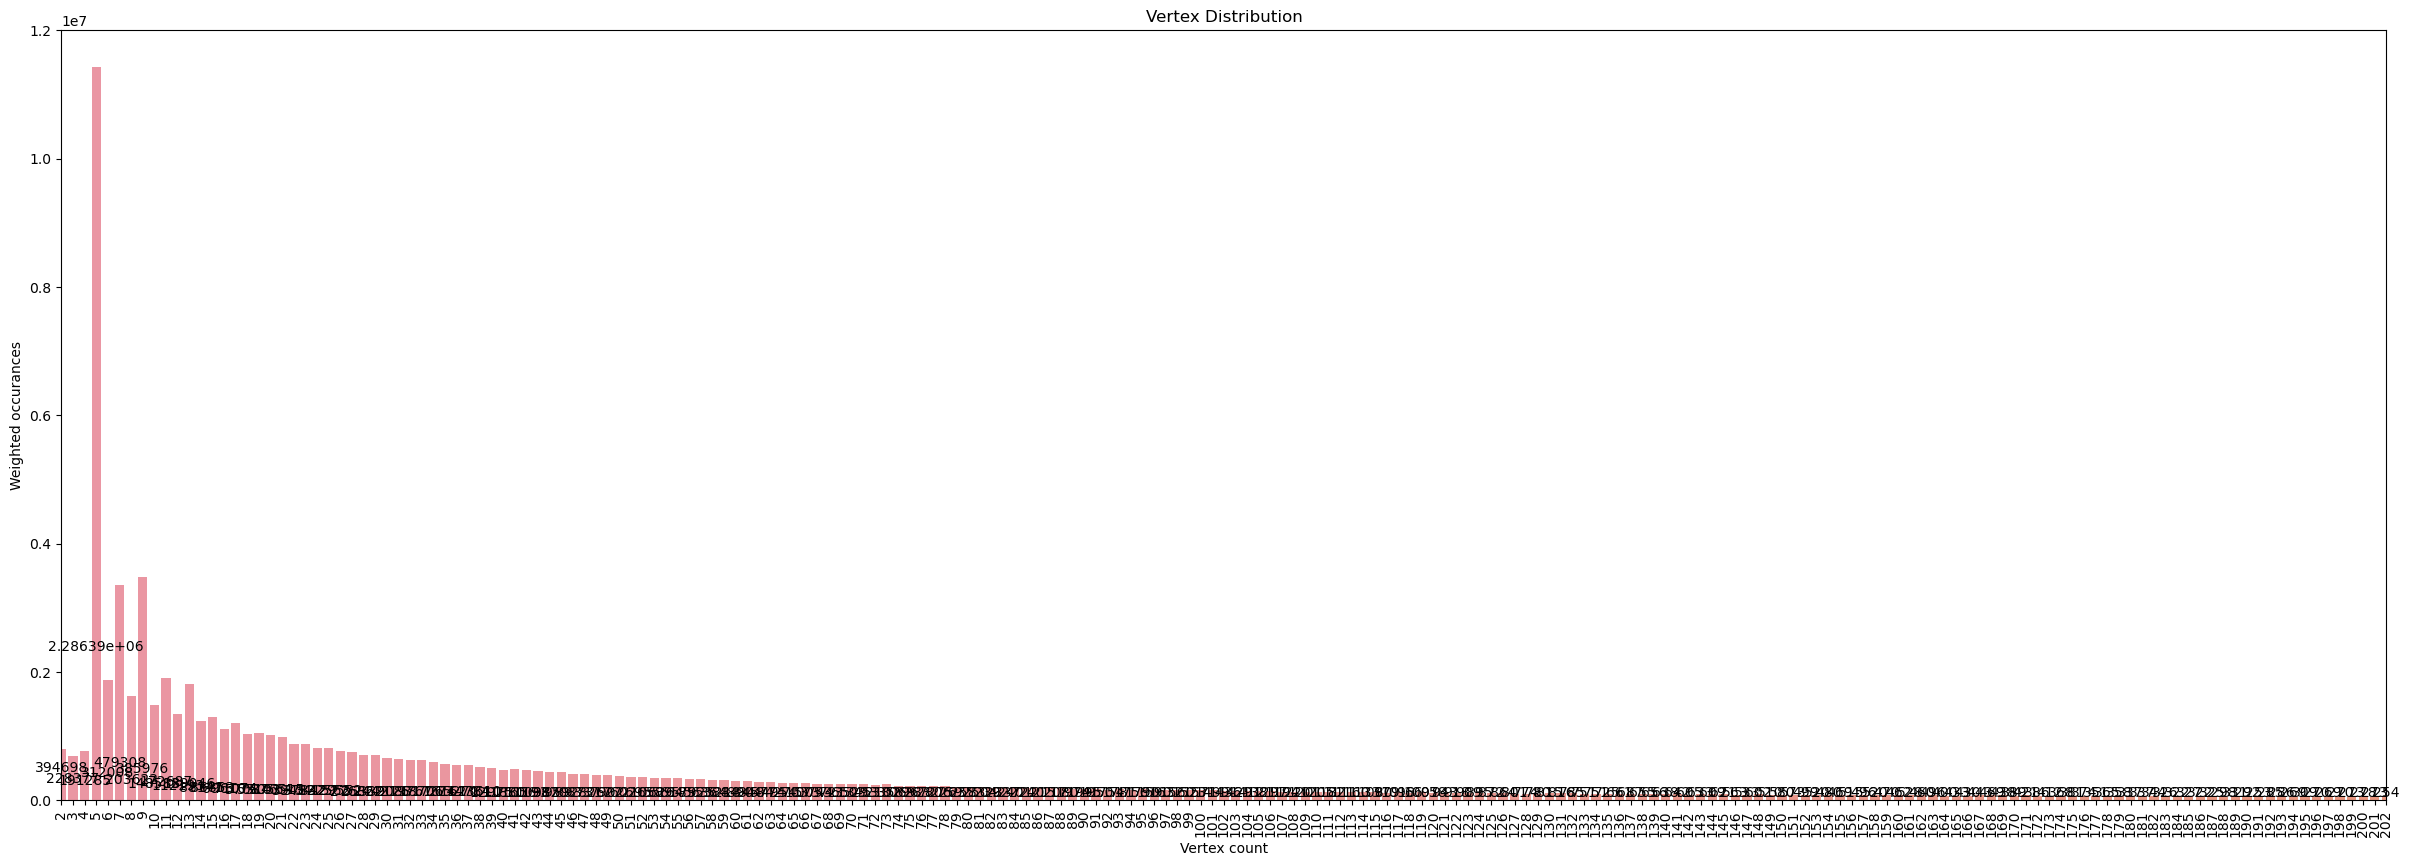

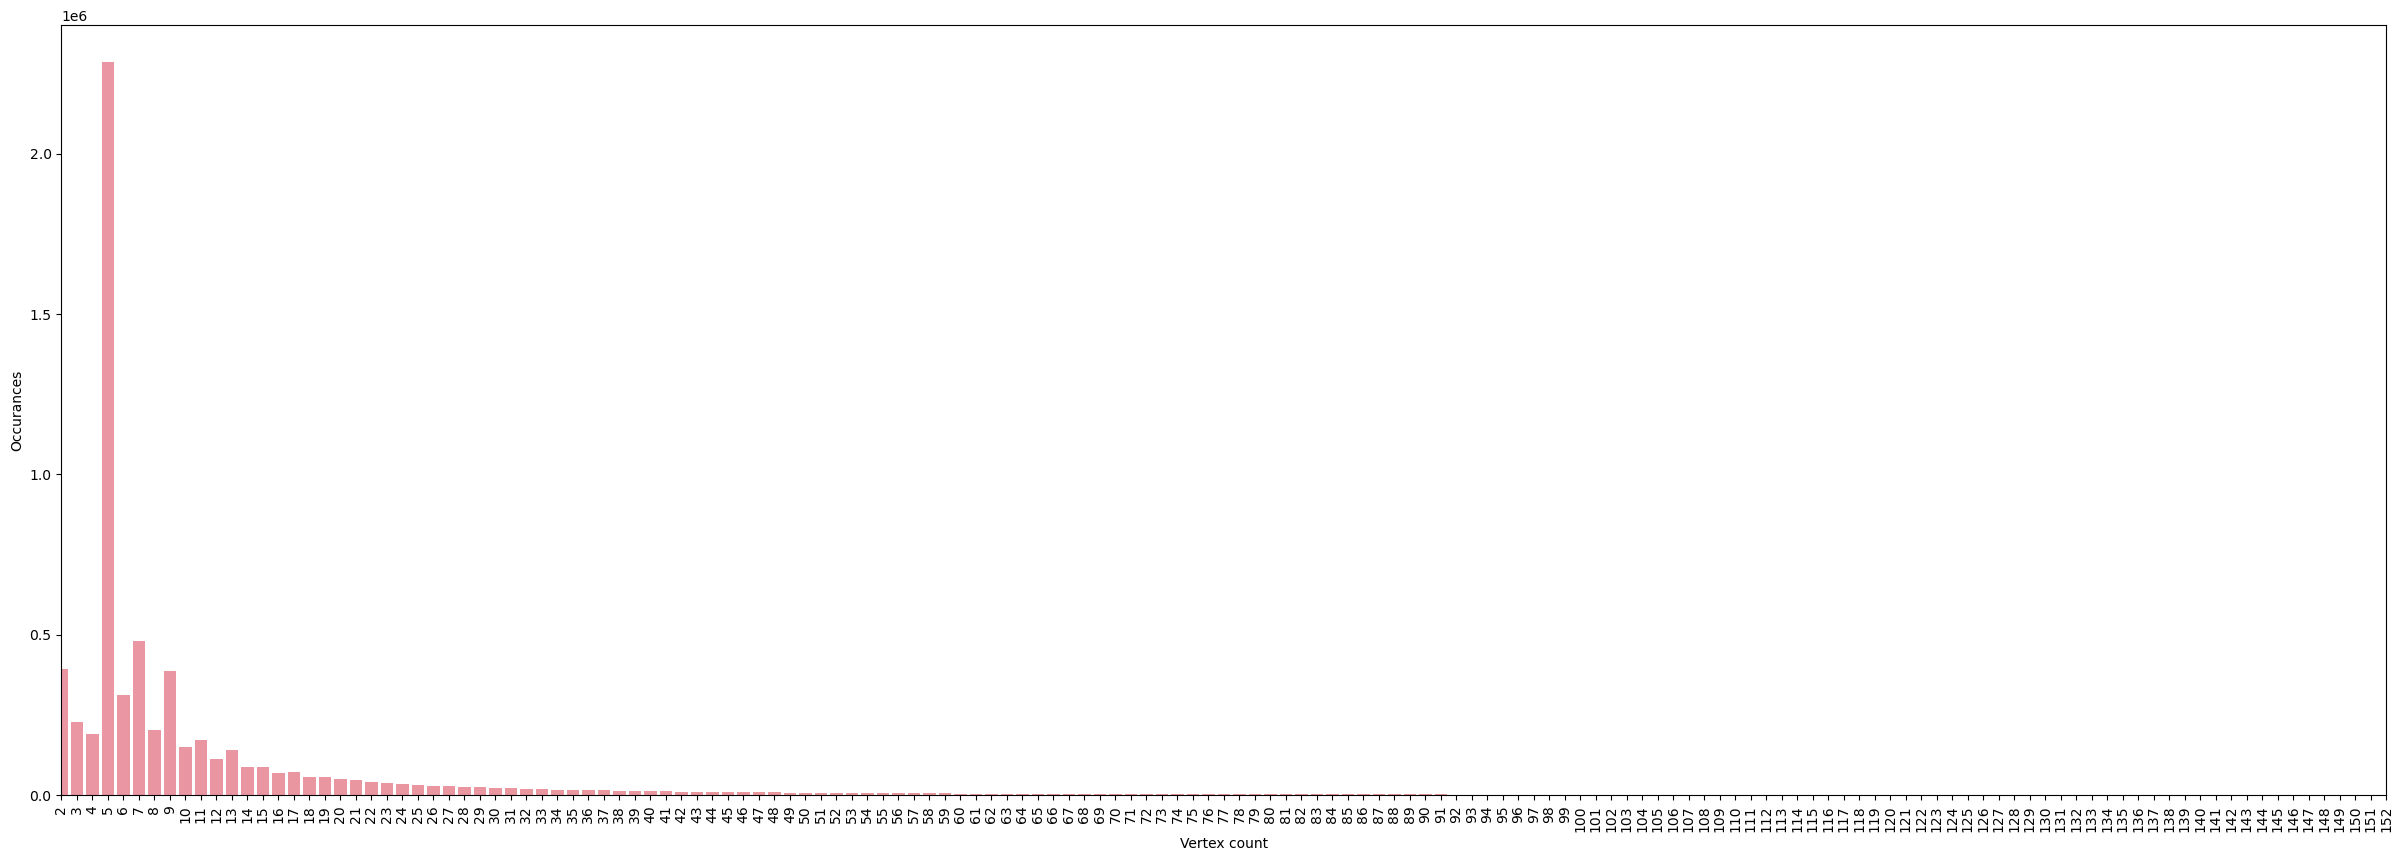

In [15]:
df_vert = op_df['verticies']
v_cnt = {i + 1: 0 for i in range(max(df_vert))}
for r in df_vert:
    v_cnt[r] += r
for i in range(max(df_vert)):
    if v_cnt[i+1] == 0:
        del v_cnt[i+1]
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
v_cnt = pd.DataFrame.from_dict(v_cnt, orient='index', columns=['weightedSum'])
v_cnt['count'] = v_cnt.apply(lambda x:x.weightedSum/ x.name, axis=1)
import seaborn as sns
ax = sns.barplot(x=v_cnt.index, y=v_cnt['count'],color='b')
ax.bar_label(ax.containers[0],label_type='edge')
sns.barplot(x=v_cnt.index, y=v_cnt.weightedSum,orient='v')
plt.xlabel("Vertex count")
plt.ylabel("Weighted occurances")
plt.xlim([0, 200])
plt.title("Vertex Distribution")
plt.show()

plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
ax = sns.barplot(x=v_cnt.index, y=v_cnt['count'])
plt.xlabel("Vertex count")
plt.ylabel("Occurances")
plt.xlim([0, 150])
plt.title("")
plt.show()

Geom cnt: 6381298
Polygon         0.680289
LineString      0.318738
MultiPolygon    0.000973
Name: type, dtype: float64
Vert sum, avg: 104527169 16.380236277948466


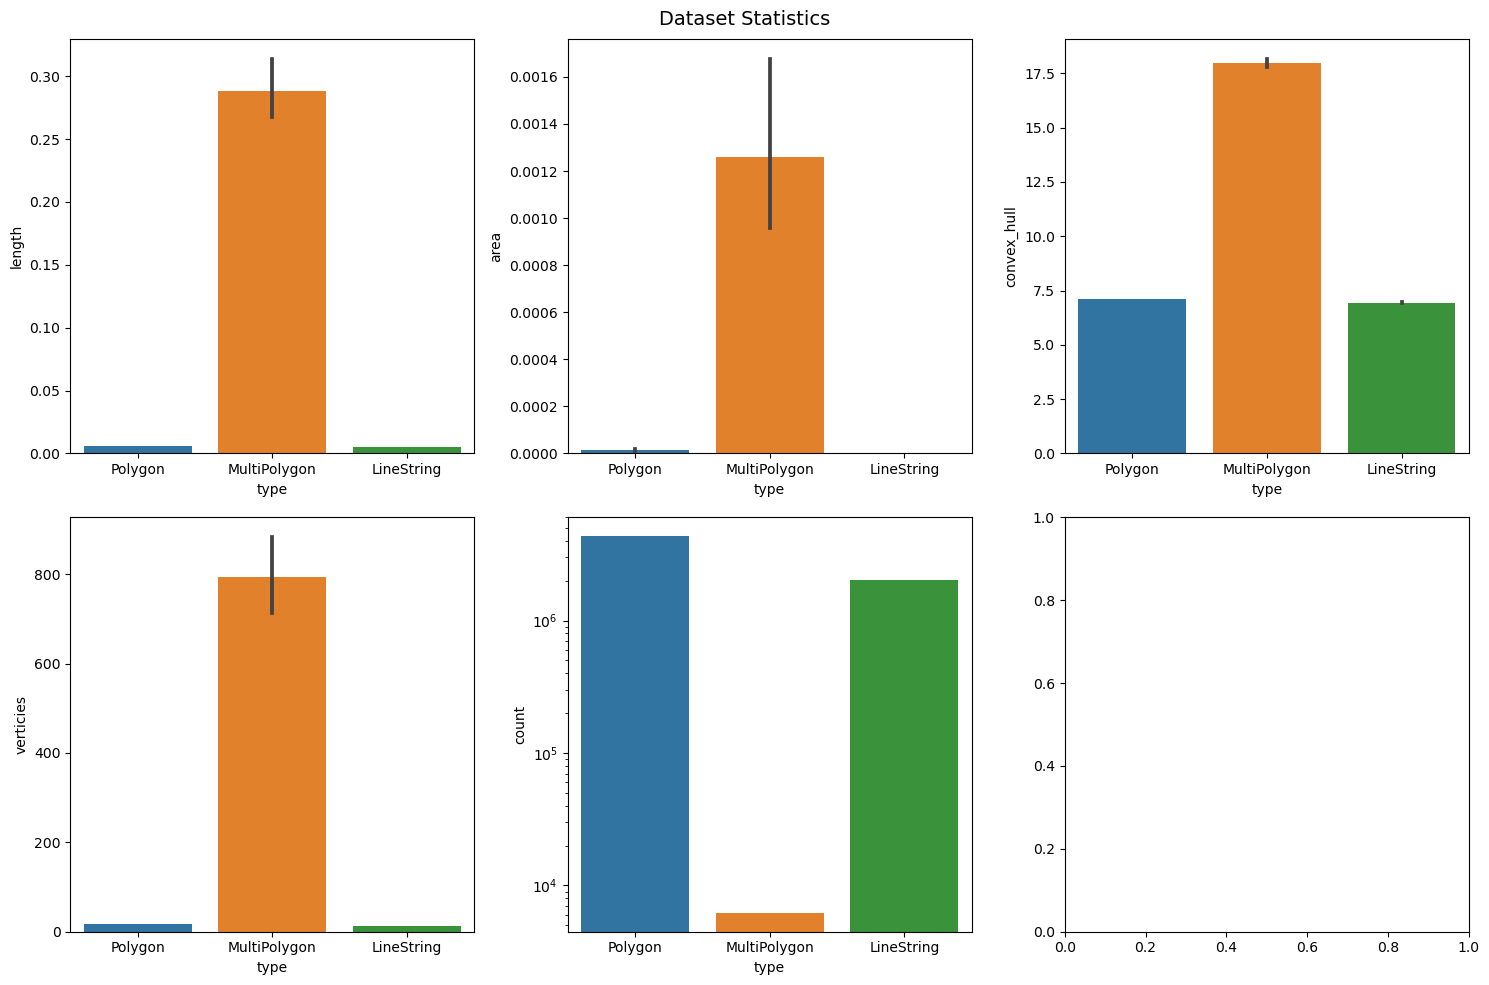

In [11]:
print("Geom cnt:", len(op_df))
print(op_df['type'].value_counts(normalize=True))
print("Vert sum, avg:", op_df['verticies'].sum(), op_df['verticies'].mean())

figure, axis = plt.subplots(2, 3)
figure.set_figwidth(15)
figure.set_figheight(10)
figure.suptitle("Dataset Statistics", fontsize=14)

sns.barplot(data=op_df, x='type', y='area',ax=axis[0,1])
sns.barplot(data=op_df, x='type', y='length',ax=axis[0,0])
sns.barplot(data=op_df, x='type', y='verticies',ax=axis[1,0])
sns.barplot(data=op_df, x='type', y='convex_hull',ax=axis[0,2])

if INCL_INTERSECTION_DATA:
    sns.barplot(data=op_df, x='type', y='intersection',ax=axis[1,2])
    
g = sns.countplot(x=op_df["type"],ax=axis[1,1])
g.set_yscale("log")
plt.tight_layout()
plt.show()